# Retrain the Convnext model with the FC classification head and visualize in UMAP and compare with results from de novo model

<b> What is done here? <b>

This notebook loads a pre-trained ConvNeXt model, modifies it by adding a classification head, consisting of an FC layer, checks if the weights of this remains unchanged compared to the original convnext model, then we retrain this new convnext model in 2 cases:

* Case 1: Retrain by showing the model 1000 instances of class 0 and 1000 instances of class 2, then evealuate accuarcy and plot UMAP on balanced testset (same as the one we used for de novo model).
* Case 2: Retrain by showing the model 1000 instances of class 0, 1000 instances of class 1 and 1000 instances of class 2, then evealuate accuarcy and plot UMAP on balanced testset (same as the one we used for de novo model).


Thus, we don't retrain in an epoch-based manner as we don't want Convnext to "forget" if we pass in too mayn class specific labels form our biological classes of interest!

<b> ConvNeXt architecture <b>

ConvNeXt is a convolutional neural network inspired by modern vision transformers (e.g., ViT) but maintains the simplicity of traditional convolution-based architectures like ResNet. It modifies standard CNNs to align closer to transformer architectures in their ability to capture long-range dependencies and achieve better performance.

The input image is divided into non-overlapping patches (similar to ViT).
Each patch is passed through a convolution layer to produce patch embeddings.

The encoder is divided into 4 stages, where each stage processes feature maps with different resolutions. Feature maps are downsampled as they progress through stages. The downsampling layers reduce the spatial dimensions (e.g. 2×2 convolutions with a stride of 2). Channel dimensions are increased to maintain feature representation. Key building blocks for processing feature maps. Uses depthwise separable convolutions (DWConv) for efficiency. The feature transformations involve: Layer Normalization (ConvNextLayerNorm), two-pointwise convolutions (PWConv1 and PWConv2), non-linear activation (GELU), dropPath regularization for robustness. 

Regardijg output: Each stage outputs a feature map that can be used for downstream tasks (e.g., classification, detection, or segmentation) or transfer learning or feature extraction.


Thus, the provided model consists of the following layers as follows:

* Embeddings:
Initial convolution layers split the image into 4×4 patches and map them to 256-dimensional embeddings.
ConvNeXtEncoder:

* Contains 4 stages:
Stage 1: Processes low-level features (spatial resolution is largest here).
Stage 2: Downsamples to 1/2 of the resolution and increases channels to 512.
Stage 3: Further downsampling and feature extraction (channels = 1024).
Stage 4: Final stage, channels = 2048.

* Decoder:
The code explicitly excludes the decoder (e.g., classification head). The model ends at the encoder, so it outputs high-dimensional feature representations.

In [1]:
!pip install numpy==1.26.4 torch==2.1.0 torchvision==0.16.0 \
    transformers==4.48.1 pillow==9.2.0 anndata==0.10.3 scanpy==1.9.6 \
    matplotlib gputil leidenalg umap-learn h5py requests \
    "scikit-learn>=0.24" statsmodels==0.14.4 session-info patsy \
    safetensors==0.5.2 tokenizers==0.21.0 huggingface-hub==0.27.1 \
    llvmlite==0.44.0 numba==0.61.0 stdlib-list==0.11.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 18.2 MB 1.6 MB/s eta 0:00:01
     |██████████████████              | 378.4 MB 108.0 MB/s eta 0:00:03   |███                             | 60.8 MB 34.6 MB/s eta 0:00:18

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |██████████████████████████████▏ | 631.1 MB 119.8 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 6.9 MB 35.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 37.7 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 36.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 43.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 37.1 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 40.7 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 41.4 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 43.1 MB/s eta 0:00:01
     |████████████████████████████████| 461 kB 45.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 42.3 MB/s eta 0:00:01
     |████████████████████████████████| 450 kB 45.8 MB/s eta 0:00:01
     |████████████████████████████████| 42.4 MB 43.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 39.9 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 28.8 MB/s eta 0:00:01
     |████████████████████████████

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 410.6 MB 130.3 MB/s eta 0:00:01
     |████████████████████████████████| 23.7 MB 37.0 MB/s eta 0:00:01
     |████████████████████████████▉   | 659.9 MB 22.0 MB/s eta 0:00:04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 731.7 MB 83.3 MB/s eta 0:00:01
     |████████████████████████████████| 14.1 MB 39.2 MB/s eta 0:00:01
     |████████████████████████████████| 196.0 MB 16.8 MB/s eta 0:00:01
     |████████████████████████████████| 124.2 MB 85.6 MB/s eta 0:00:01
     |████████████████████████████████| 121.6 MB 73.4 MB/s eta 0:00:01
     |████████████████████████████████| 209.8 MB 63.6 MB/s eta 0:00:016 MB 39.6 MB/s eta 0:00:06     |██████████████████████████████▋ | 200.8 MB 74.1 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 24.5 MB/s eta 0:00:01
     |████████████████████████████████| 39.3 MB 42.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 37.7 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 35.6 MB/s eta 0:00:01
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=005ff127b886be307635eb8bc06c9a917899201bc389e9f5fbb8a1c4e4e87615
  Stored in directory: /tmp/pip-ephem-wheel-cache-zpwq7

In [2]:
!pip install matplotlib-venn matplotlib numpy upsetplot venn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 40 kB 2.3 MB/s eta 0:00:01
  distutils: /tmp/pip-build-env-0jog3pg_/normal/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-0jog3pg_/normal/local/lib/python3.10/dist-packages
  distutils: /tmp/pip-build-env-0jog3pg_/normal/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-0jog3pg_/normal/local/lib/python3.10/dist-packages
  user = False
  home = None
  root = None
  prefix = '/tmp/pip-build-env-0jog3pg_/normal'
  distutils: /tmp/pip-build-env-0jog3pg_/overlay/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-0jog3pg_/overlay/local/lib/python3.10/dist-packages
  distutils: /tmp/pip-build-env-0jog3pg_/overlay/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-0jog3pg_/overlay/local/lib/python3.10/dist-packages
  user = False
  home = None
  root = None
  prefix = '/tmp/pip-build-env-0jog3pg_/overlay'
  Installing build dependencies .

In [3]:
import numpy
print(numpy.__version__)

1.26.4


In [2]:
# Standard library imports
import os
import re
import glob
import random
#import pandas as pd
import pickle
from collections import Counter

# Third-party imports
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, utils
import numpy as np
import h5py
import umap
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import requests

# Transformers library imports
from transformers import AutoImageProcessor, ConvNextModel, ConvNextConfig

# Project-specific imports
from sparcscore.ml.datasets import HDF5SingleCellDataset
from sparcscore.ml.transforms import RandomRotation, GaussianNoise, ChannelReducer, ChannelSelector
from sparcscore.ml.utils import combine_datasets_balanced
from sparcscore.ml.pretrained_models import autophagy_classifier2_1

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NOTE! Installing ujson may make loading annotations faster.


In [3]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 1.8 MB 3.0 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    distutils: /usr/bin
    sysconfig: /usr/local/bin
    user = False
    home = None
    root = None
    prefix = None
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


In [2]:
#feature_extractor = AutoImageProcessor.from_pretrained("facebook/convnext-xlarge-224-22k")
feature_extractor = AutoImageProcessor.from_pretrained("facebook/convnext-xlarge-224-22k", do_rescale=False)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Adding a classification head

* Step 1: Modify the forward function to add a classification head.
* Step 2: Verify that the classification head’s weights have been correctly loaded before and after initializing the FC layer.

In [5]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load configuration for ConvNext
config = ConvNextConfig.from_pretrained("facebook/convnext-xlarge-224-22k")

# Load the pretrained ConvNext model
original_model = ConvNextModel.from_pretrained("facebook/convnext-xlarge-224-22k")
original_model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:783: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ConvNextModel(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            

In [32]:
original_model.eval()  

# Save the original model's weights for comparison
original_weights = {name: param.clone().detach() for name, param in original_model.named_parameters()}

In [ ]:
# model with a classification head
class ConvNextWithCustomFC(ConvNextModel):
    def __init__(self, config, num_classes=2):
        super().__init__(config)
        # FC layer for classification
        self.fc = nn.Linear(config.hidden_sizes[-1], num_classes)

    def forward(self, pixel_values, **kwargs):
        outputs = super().forward(pixel_values, **kwargs)
        
        # Extracct the pooled output
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            # Perform mean pooling across the spatial dimensions
            embeddings = outputs.last_hidden_state.mean(dim=1)
        
        # Pass embedings through classification head
        logits = self.fc(embeddings)
        return logits

# Init this model
model = ConvNextWithCustomFC.from_pretrained("facebook/convnext-xlarge-224-22k", config=config, num_classes=2)
model.to(device)

In [8]:
# Save the weights of the new model's FC layer for reference
initial_fc_weights = model.fc.weight.clone().detach()
print("Initial FC layer weights:", initial_fc_weights)

Initial FC layer weights: tensor([[-0.0406,  0.0152,  0.0210,  ..., -0.0176,  0.0049, -0.0191],
        [-0.0182, -0.0093,  0.0143,  ...,  0.0011, -0.0100, -0.0003]],
       device='cuda:0')


In [9]:
# Compare ConvNeXt backbone weights before and after adding the classification head
for name, param in model.named_parameters():
    if name in original_weights:
        if torch.equal(param, original_weights[name]):
            print(f"Backbone weights for {name} are unchanged.")
        else:
            print(f"Backbone weights for {name} have changed! Oh no.")

Backbone weights for embeddings.patch_embeddings.weight are unchanged.
Backbone weights for embeddings.patch_embeddings.bias are unchanged.
Backbone weights for embeddings.layernorm.weight are unchanged.
Backbone weights for embeddings.layernorm.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.layer_scale_parameter are unchanged.
Backbone weights for encoder.stages.0.layers.0.dwconv.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.dwconv.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.layernorm.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.layernorm.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv1.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv1.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv2.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv2.bias are unchanged.
Backbone weights for encoder.stages.0.la

Why do we check this? When modifying a model's architecture, there's always a chance that some part of the code unintentionally modifies the backbone weights. We want to avoid accidentally reinitializing the entire model, misconfiguring the initialization logic or making modifications to the computation graph affecting shared weights, etc.

### Retrain ConvNeXt 

1) on a couple thousand instances of the classes 0 and 2 to be able to compare it with the de novo model results and 2) on a couple thousand instances of the classes 0,1 and 2.

We only pass a few thousand examples in order not to train it too much for it to “forget”. Then plot the UMAP of the same balanced testset instances containing all 6 biological classes.

In [10]:
def sample_cells(dataset, class_label, n_samples, exclude_indices=[]):
    # Get all valid entries for the given class_label
    valid_entries = [entry for entry in dataset.data_locator if entry[0] == class_label]
    
    # entry[2] gives the index within that specific dataset
    cell_indices = [(entry[1], entry[2]) for entry in valid_entries]  # (handle_id, cell_index) tuple
    
    # Remove excluded indices 
    cell_indices = [ci for ci in cell_indices if ci[1] not in exclude_indices]

    # ccheck if the available cells are fewer than requested
    if len(cell_indices) < n_samples:
        print(f"Warning: Requested {n_samples} samples, but only {len(cell_indices)} available.")
        n_samples = len(cell_indices)
    
    sampled_indices = random.sample(cell_indices, n_samples) # Returns (handle_id, cell_index) pairs
    
    return sampled_indices  

In [11]:
def create_trainset(dataset, train_filename_template, testset_indices, class_labels, n_samples_per_class=100000):
    trainset_indices = {}

    # Flatten testset indices so that we can exclude them from the training set
    testset_all_indices = set([(entry[0], entry[1]) for entries in testset_indices.values() for entry in entries])

    # Sample cells from the selected classes, excluding testset indices
    for class_label in class_labels:
        print(f"Sampling for class {class_label}")
        
        # Sample cells and exclude those that are already in the test set
        sampled_cell_indices = sample_cells(dataset, class_label, n_samples_per_class, exclude_indices=testset_all_indices)
        trainset_indices[class_label] = sampled_cell_indices
        
        # Save each class' training set to a separate HDF5 file
        train_filename = train_filename_template.format(label=class_label)
        
        with h5py.File(train_filename, 'w') as f:
            # Create lists to store data before writing to HDF5
            cell_data_list = []
            cell_index_list = []
            annotation_list = []
            
            # Track local index (starting from 0 for each new file)
            local_index = 0
            
            # Loop over the sampled cell indices
            for global_cell_id, (handle_id, cell_index) in enumerate(sampled_cell_indices):
                # Retrieve the correct entry from data_locator using (handle_id, cell_index) pair
                entry = next((entry for entry in dataset.data_locator if entry[1] == handle_id and entry[2] == cell_index), None)
                
                if entry is None:
                    print(f"Warning: No entry found for handle_id {handle_id} and cell_index {cell_index}. Skipping.")
                    continue

                try:
                    # Retrieve the single-cell data from the correct handle
                    data = dataset.handle_list[handle_id][cell_index] 
                except KeyError:
                    print(f"Error: Data not found for handle_id {handle_id}, cell_index {cell_index}.")
                    continue

                # The class label (from the data locator)
                label = entry[0]  # Class label from the entry

                # Append data and the corresponding local index for this file
                cell_data_list.append(data)
                
                # Use local_index (for the new train file) and the original cell_index
                cell_index_list.append([local_index, local_index])  # Use local_index and the original cell_index
                
                # Annotation: store local_index, original cell_index, and class label as encoded strings
                annotation_list.append([str(local_index).encode(), str(cell_index).encode(), str(label).encode()])

                local_index += 1  # Increment the local index for each cell

            # Convert lists to numpy arrays before saving
            if len(cell_data_list) > 0:
                single_cell_data = np.array(cell_data_list, dtype='float16')  # Shape: (n_cells, channels, height, width)
                single_cell_index = np.array(cell_index_list, dtype=np.uint64)  # Shape: (n_cells, 2)
                annotation = np.array(annotation_list, dtype='S')  # Shape: (n_cells, 3), string-encoded data

                # Write to HDF5
                f.create_dataset('single_cell_data', data=single_cell_data, dtype='float16')
                f.create_dataset('single_cell_index', data=single_cell_index, dtype='uint64')
                f.create_dataset('annotation', data=annotation, dtype=h5py.special_dtype(vlen=bytes))
            else:
                print(f"Warning: No valid data found for class {class_label}.")
    
    return trainset_indices

In [5]:
# Check for overlap between testset and trainset indices
def check_overlap(testset_indices, trainset_indices):
    testset_all_indices = set([idx for indices in testset_indices.values() for idx in indices])  # Flatten testset indices
    trainset_all_indices = set([idx for indices in trainset_indices.values() for idx in indices])  # Flatten trainset indices
    overlap = testset_all_indices.intersection(trainset_all_indices)
    
    if overlap:
        print(f"Warning: Overlapping indices found between testset and trainset: {overlap}")
    else:
        print("No overlap between testset and trainset.")

In [40]:
os.chdir('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/')
files = os.listdir()
print("Files in 230714_autophagy_training_data_sample:")
for file in files:
    print(file)
print("\n")

Files in 230714_autophagy_training_data_sample:
balanced_testset.pt
testset_0.h5
testset_1.h5
testset_indices.pkl
testset_5.h5
testset_3.h5
testset_4.h5
testset_2.h5




In [6]:
# Load the testset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_indices.pkl', 'rb') as f:
    testset_indices = pickle.load(f)

In [10]:
directory = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/'
#directory = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/'
file_pattern = os.path.join(directory, 'trainset_*.h5')

# Get a list of all matching files
files_to_delete = glob.glob(file_pattern)

# Loop through the files and delete them
for file_path in files_to_delete:
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except OSError as e:
        print(f"Error deleting file {file_path}: {e}")

# checking if any files remain
remaining_files = glob.glob(file_pattern)
if not remaining_files:
    print("All files deleted successfully.")
else:
    print(f"Remaining files: {remaining_files}")

All files deleted successfully.


In [22]:
os.chdir('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/')
files = os.listdir()
for file in files:
    print(file)
print("\n")

trainset_indices.pkl




In [4]:
full_hdf5_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_0d.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5'],
    dir_labels=[4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 3426407
0: 407464
1: 209030
2: 400000
3: 9346
4: 7476
5: 2393091


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load configuration for ConvNext
config = ConvNextConfig.from_pretrained("facebook/convnext-xlarge-224-22k")

# Define a custom model with a classification head
class ConvNextWithCustomFC(ConvNextModel):
    def __init__(self, config, num_classes=2):
        super().__init__(config)
        # Add a fully connected layer for classification
        self.fc = nn.Linear(config.hidden_sizes[-1], num_classes)

    def forward(self, pixel_values, **kwargs):
        # Forward pass through the base ConvNextModel
        outputs = super().forward(pixel_values, **kwargs)
        
        # Extract the embeddings
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Fallback to mean pooling
        
        # Pass embeddings through the classification head
        logits = self.fc(embeddings)
        return logits, embeddings

# Initialize custom model
model = ConvNextWithCustomFC.from_pretrained("facebook/convnext-xlarge-224-22k", config=config, num_classes=3)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ConvNextWithCustomFC were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.fc.bias', 'convnext.fc.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextWithCustomFC(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
     

In [6]:
def load_dataset(save_path, batch_size):
    """
    Load dataset with images, labels, and cell IDs.

    Parameters:
    - save_path: Path where the dataset is stored
    - batch_size: Batch size for DataLoader

    Returns:
    - DataLoader for the dataset
    """
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)

    # Create a TensorDataset from the loaded tensors
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Loaded dataset from {save_path}")
    return data_loader

# Load the balanced test dataset
test_data_loader = load_dataset(
    "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt",
    batch_size=64
)

Loaded dataset from /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt


#### Case 1 [0,2 | balanced testset] with only 1000 instances per class (small!)

In [10]:
train_class_labels = [0, 2] 

In [11]:
import h5py

# Close all open HDF5 files
for obj in h5py.File.__dict__.values():
    if isinstance(obj, h5py.File):
        obj.close()


In [12]:
# Create training set with separate files for selected class labels
train_filename_template = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/trainset_{label}.h5'
trainset_indices = create_trainset(full_hdf5_data, train_filename_template, testset_indices, class_labels=train_class_labels, n_samples_per_class = 1000)
#check_overlap(testset_indices, trainset_indices)

Sampling for class 0
Sampling for class 2


In [11]:
balanced_trainset_class_0_and_2 = HDF5SingleCellDataset(
    dir_list=[f'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/trainset_{label}.h5' for label in train_class_labels],
    dir_labels=train_class_labels,  # The class labels
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/',  
    select_channel=4,  # Select the 5th channel
    return_id=False
)

Total: 2000
0: 1000
2: 1000


In [14]:
# Save the trainset_indices to a file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/trainset_indices.pkl', 'wb') as f:
    pickle.dump(trainset_indices, f)

In [12]:
# Load the trainset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/trainset_indices.pkl', 'rb') as f:
    trainset_indices = pickle.load(f)

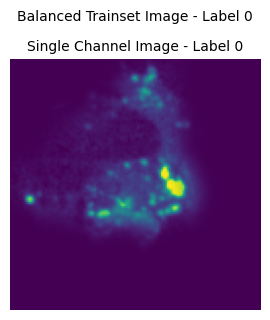

In [13]:
image_data, label = balanced_trainset_class_0_and_2[0]  # Unpack image data, label from tupel
num_channels = image_data.shape[0]  # number of channels

if num_channels == 1:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(image_data[0]) 
    ax.set_title(f"Single Channel Image - Label {label}", fontsize=10)
    ax.axis('off')

else:
    fig, axes = plt.subplots(1, num_channels, figsize=(10, 5))
    
    for channel in range(num_channels):
        axes[channel].imshow(image_data[channel])
        axes[channel].set_title(f"Channel {channel + 1}")
        axes[channel].axis('off')
        
plt.tight_layout()
plt.suptitle(f"Balanced Trainset Image - Label {label}", fontsize=10, y=1.05)
plt.show()

In [14]:
# Load data: Balanced trainset for classes 0 and 2
train_class_labels = [0, 2]
balanced_trainset_class_0_and_2 = HDF5SingleCellDataset(
    dir_list=[
        f'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/trainset_{label}.h5'
        for label in train_class_labels
    ],
    dir_labels=train_class_labels,  # Class labels
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/',
    select_channel=4,  # Select the 5th channel
    return_id=False
)
train_loader = DataLoader(balanced_trainset_class_0_and_2, batch_size=64, shuffle=True, num_workers=8)

Total: 2000
0: 1000
2: 1000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
import torch
torch.cuda.empty_cache()

In [27]:
print(torch.cuda.memory_summary(device='cuda'))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  15908 MiB |  15912 MiB |  18440 MiB |   2532 MiB |
|       from large pool |  15887 MiB |  15891 MiB |  18415 MiB |   2528 MiB |
|       from small pool |     20 MiB |     21 MiB |     25 MiB |      4 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  15908 MiB |  15912 MiB |  18440 MiB |   2532 MiB |
|       from large pool |  15887 MiB |  15891 MiB |  18415 MiB |

In [15]:
def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1) 

In [20]:
import torch
from torch.optim import Adam
import numpy as np
import umap
import matplotlib.pyplot as plt

#device = torch.device('cpu')
#model.to(device)

# training mode
model.train()

optimizer = Adam(model.parameters(), lr=1e-5) 

# Define loss function 
criterion = nn.CrossEntropyLoss()

running_loss = 0.0
correct_preds = 0
total_preds = 0 

for batch in train_loader:
    optimizer.zero_grad()  # Zero gradients
    
    # Extract inputs and labels
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Convert inputs from single-channel to 3 channels
    inputs = convert_to_rgb(inputs)
    
    # Forward pass through the model
    logits, embeddings = model(inputs)  # Unpack the tuple returned by the model

    # Compute loss using only the logits
    loss = criterion(logits, labels)
    
    # Backward pass and optimization step
    loss.backward()
    optimizer.step()
    
    # Track accuracy
    _, predicted = torch.max(logits, 1)
    total_preds += labels.size(0)
    correct_preds += (predicted == labels).sum().item()
    
    # Accumulate loss for visualization
    running_loss += loss.item()
    
# Calculate and print final accuracy after one pass
accuracy = 100 * correct_preds / total_preds
print(f'Finished one pass through training data. Accuracy: {accuracy:.2f}%')

Finished one pass through training data. Accuracy: 83.40%


In [16]:
# Define the directory and filename
save_dir = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
model_filename = "model_case_1_1000_instances.pth"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save model
model_path = os.path.join(save_dir, model_filename)

In [22]:
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/model_case_1_1000_instances.pth


In [17]:
# Load the saved model
model.load_state_dict(torch.load(model_path))
model.to(device)

ConvNextWithCustomFC(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
     

In [18]:
embeddings = []
labels_list = []
cell_ids_list = []  

model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        inputs, labels, cell_ids = batch  
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Convert inputs from single-channel to 3 channels
        inputs = convert_to_rgb(inputs)

        # Forward pass to get logits and pooler output
        _, pooler_output = model(inputs)

        # Append pooler_output, labels, and cell_ids
        embeddings.append(pooler_output.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        cell_ids_list.append(cell_ids.cpu().detach().numpy())  

# Convert to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)
cell_ids_list = np.concatenate(cell_ids_list, axis=0) 

In [24]:
embeddings

array([[ 1.01102304e+00, -4.60396957e-04, -3.69742280e-04, ...,
         8.86378169e-01,  1.05480492e-01,  4.69405651e-01],
       [ 3.76809239e-01, -5.94556739e-04,  5.21851820e-04, ...,
         1.29389450e-01,  2.16637120e-01, -3.21303159e-02],
       [ 1.61925241e-01, -5.48389798e-04,  1.25301466e-03, ...,
         1.91409364e-01,  7.15575069e-02,  1.46858245e-01],
       ...,
       [ 3.62965167e-01, -4.81972034e-04,  1.08553015e-03, ...,
         8.01141486e-02,  2.21746996e-01, -1.08422451e-01],
       [ 5.31294346e-01, -5.37727552e-04,  8.19680979e-04, ...,
         2.10782677e-01,  1.67991132e-01, -1.15069434e-01],
       [-9.76449475e-02, -6.61264523e-04,  4.34237532e-04, ...,
        -2.73883212e-02,  4.52336431e-01,  1.09931706e-02]], dtype=float32)

In [25]:
labels_list

array([5, 3, 2, ..., 1, 2, 1])

In [26]:
cell_ids_list

array([395345, 196471,  69929, ..., 402172, 240543, 389341])

In [19]:
import pickle
import os

# Define the save path
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
file_name = "case_1_1000_instances.pkl"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save embeddings, labels, and cell_ids using pickle
with open(os.path.join(save_path, file_name), 'wb') as f:
    pickle.dump({'embeddings': embeddings, 'labels': labels_list, 'cell_ids': cell_ids_list}, f)

print(f"Saved embeddings, labels, and cell_ids to {os.path.join(save_path, file_name)}")

Saved embeddings, labels, and cell_ids to /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/case_1_1000_instances.pkl


In [26]:
import pickle
import os

# Define the save path and file name
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
file_name = "case_1_1000_instances.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

Loaded embeddings shape: (12000, 2048)
Loaded labels shape: (12000,)
Loaded cell_ids shape: (12000,)


In [20]:
# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

#UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

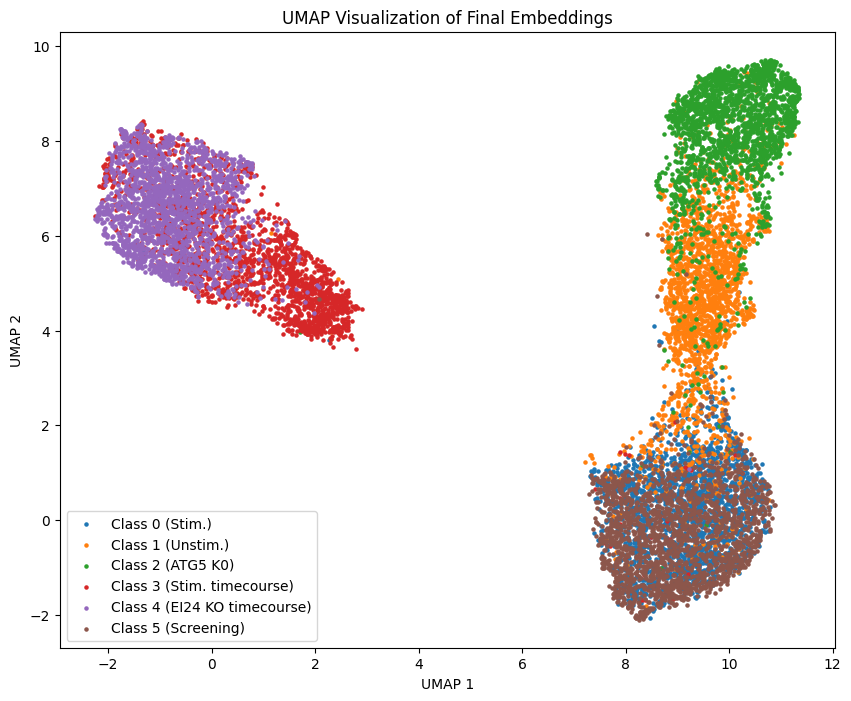

In [21]:
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"]

# Visualize UMAP
plt.figure(figsize=(10, 8))

for i, label in enumerate(class_labels):
    # Select indices for each class
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)

plt.legend()
plt.title('UMAP Visualization of Final Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

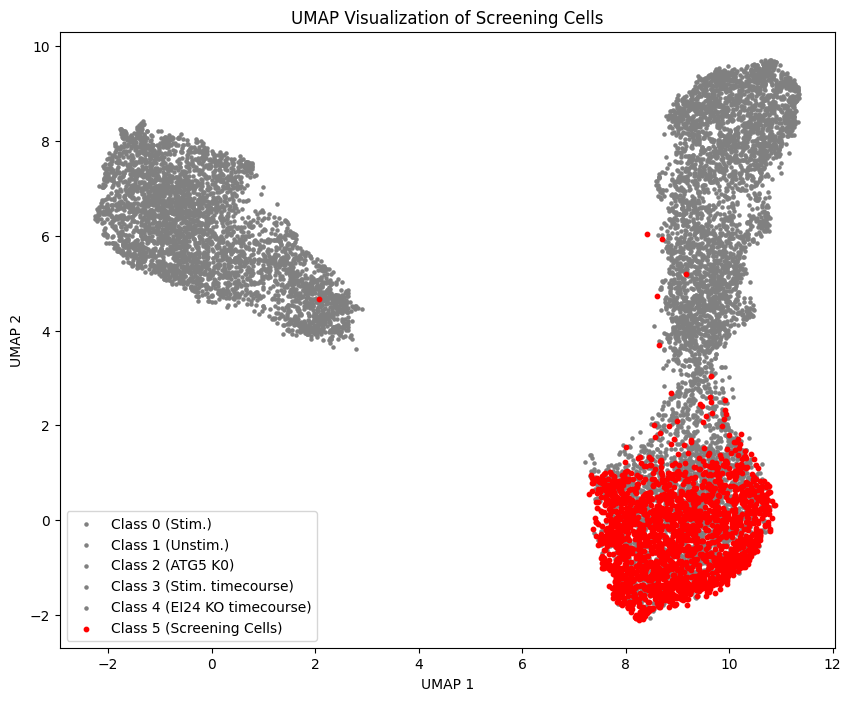

In [28]:
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Stim. timecourse)", 
                "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"]

# Plotting UMAP only for Screening cells
plt.figure(figsize=(10, 8))

# Plot cells belonging to other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Exclude the last class (screening)
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

# Plot cells belonging to class 5 (screening) with red color
screening_idx = labels_list == 5
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], color='red', label='Class 5 (Screening Cells)', s=10)

# Add legend and labels
plt.legend()
plt.title('UMAP Visualization of Screening Cells')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Show plot
plt.show()

In [39]:
# Extract UMAP coordinates
x_coords = umap_result[:, 0]  # UMAP X-coordinates
y_coords = umap_result[:, 1]  # UMAP Y-coordinates

# Identify screening cells (Class 5)
screening_idx = labels_list == 5

# Keep only Class 5 cells **outside** the block: x <= 7 and y >= 2
filtered_idx = screening_idx & (y_coords >= 2)

# Extract the filtered cell IDs
filtered_cell_ids = cell_ids_list[filtered_idx]

# Save the filtered cell IDs to a file
save_path = "./convnext_output_files/case1_1000_cells_outside_block_screening_hits.txt"
np.savetxt(save_path, filtered_cell_ids, fmt="%d")

print(f"Saved {len(filtered_cell_ids)} cell IDs to {save_path}")

Saved 21 cell IDs to ./convnext_output_files/case1_1000_cells_outside_block_screening_hits.txt


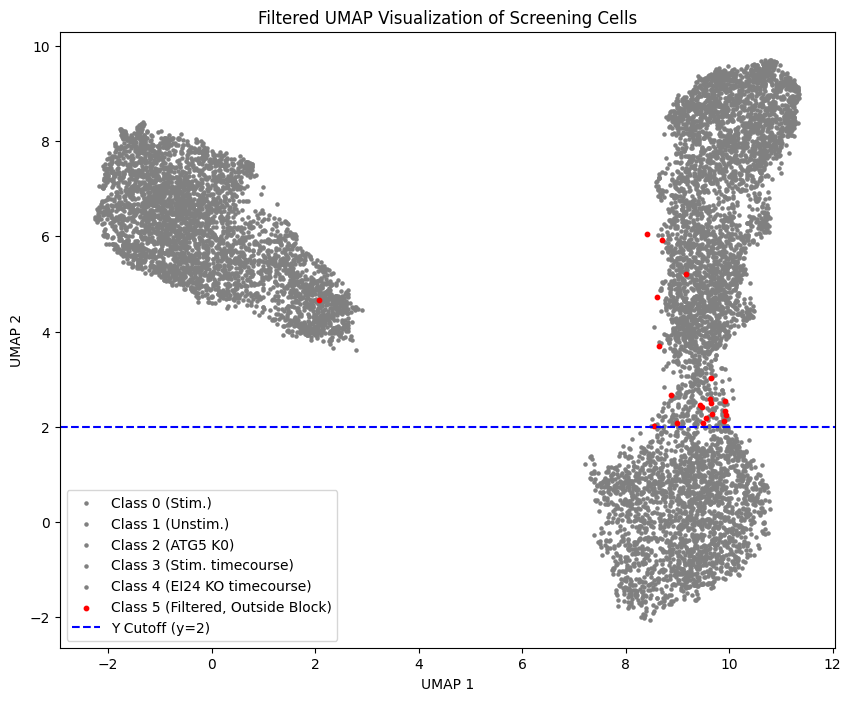

In [40]:
# Plot UMAP with Updated Cutoff
plt.figure(figsize=(10, 8))

# Plot all other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Exclude class 5
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

# Plot filtered Class 5 (Screening) cells in red (outside the block)
plt.scatter(x_coords[filtered_idx], y_coords[filtered_idx], color='red', label='Class 5 (Filtered, Outside Block)', s=10)

# Highlight the excluded region in blue
plt.axhline(y=2, color='blue', linestyle='--', label='Y Cutoff (y=2)')

plt.legend()
plt.title('Filtered UMAP Visualization of Screening Cells')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [24]:
adata = ad.AnnData(X=umap_result)

# Map numerical labels to string labels
label_map = {i: label for i, label in enumerate(class_labels)}
adata.obs['class_labels'] = labels_list
adata.obs['class_labels'] = adata.obs['class_labels'].map(label_map)

# Compute neighbors and Leiden clustering
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

colors_leiden = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
cmap_leiden = ListedColormap(colors_leiden, name='custom_discrete_cmap_leiden')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


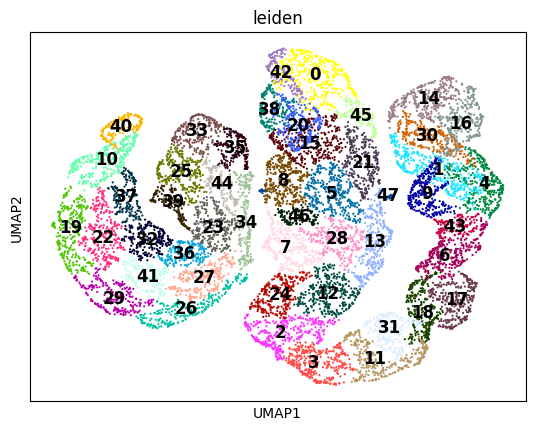

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


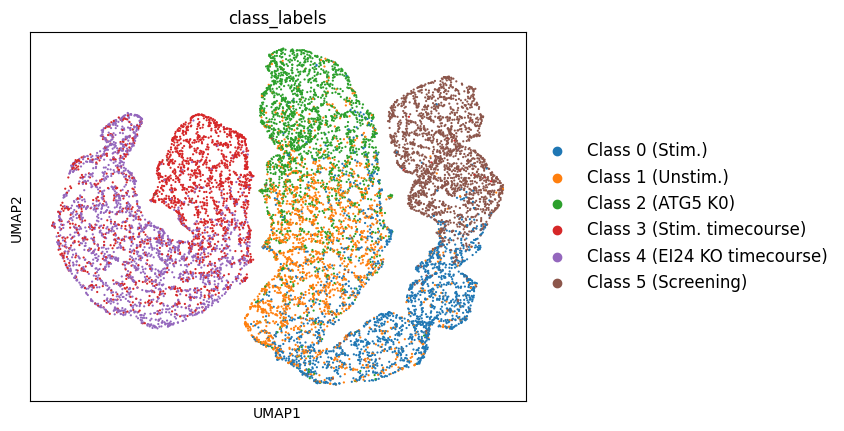

In [25]:
# Plot UMAP with Leiden clustering
sc.pl.umap(adata, color=['leiden'], cmap=cmap_leiden, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['class_labels'], cmap=cmap_leiden, legend_loc='right margin', legend_fontsize=12)

#### Case 1 [0,2 | balanced testset] with 100000 instances per class (big!)

In [7]:
# Load data: Balanced trainset for classes 0 and 2
train_class_labels = [0, 2]

balanced_trainset_class_0_and_2 = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5'],
    dir_labels=[0, 2], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

train_loader = DataLoader(balanced_trainset_class_0_and_2, batch_size=64, shuffle=True, num_workers=8)

Total: 200000
0: 100000
2: 100000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1)  

In [ ]:
import torch
from torch.optim import Adam
import numpy as np
import umap
import matplotlib.pyplot as plt

#device = torch.device('cpu')
#model.to(device)

# training mode
model.train()

optimizer = Adam(model.parameters(), lr=1e-5) 

# Define loss function 
criterion = nn.CrossEntropyLoss()

running_loss = 0.0
correct_preds = 0
total_preds = 0


for batch in train_loader:
    optimizer.zero_grad()  # Zero gradients
    
    # Extract inputs and labels
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Convert inputs from single-channel to 3 channels
    inputs = convert_to_rgb(inputs)
    
    # Forward pass through the model
    logits, embeddings = model(inputs)  # Unpack the tuple returned by the model

    # Compute loss using only the logits
    loss = criterion(logits, labels)
    
    # Backward pass and optimization step
    loss.backward()
    optimizer.step()
    
    # Track accuracy
    _, predicted = torch.max(logits, 1)
    total_preds += labels.size(0)
    correct_preds += (predicted == labels).sum().item()
    
    # Accumulate loss for visualization
    running_loss += loss.item()
    
# Calculate and print final accuracy after one pass
accuracy = 100 * correct_preds / total_preds
print(f'Finished one pass through training data. Accuracy: {accuracy:.2f}%')

In [9]:
# Define the directory and filename
save_dir = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
model_filename = "model_case_1_100000_instances.pth"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save model
model_path = os.path.join(save_dir, model_filename)

In [ ]:
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

In [10]:
# Load the saved model
model.load_state_dict(torch.load(model_path))
model.to(device)

ConvNextWithCustomFC(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
     

In [45]:
embeddings = []
labels_list = []
cell_ids_list = []  

model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        inputs, labels, cell_ids = batch  
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Convert inputs from single-channel to 3 channels
        inputs = convert_to_rgb(inputs)

        # Forward pass to get logits and pooler output
        _, pooler_output = model(inputs)

        # Append pooler_output, labels, and cell_ids
        embeddings.append(pooler_output.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        cell_ids_list.append(cell_ids.cpu().detach().numpy())  

# Convert to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)
cell_ids_list = np.concatenate(cell_ids_list, axis=0) 

In [46]:
import pickle
import os

# Define the save path
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
file_name = "case_1_100000_instances.pkl"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save embeddings, labels, and cell_ids using pickle
with open(os.path.join(save_path, file_name), 'wb') as f:
    pickle.dump({'embeddings': embeddings, 'labels': labels_list, 'cell_ids': cell_ids_list}, f)

print(f"Saved embeddings, labels, and cell_ids to {os.path.join(save_path, file_name)}")

Saved embeddings, labels, and cell_ids to /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/case_1_100000_instances.pkl


In [11]:
import pickle
import os

# Define the save path and file name
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
file_name = "case_1_100000_instances.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

Loaded embeddings shape: (12000, 2048)
Loaded labels shape: (12000,)
Loaded cell_ids shape: (12000,)


In [12]:
# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

#UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

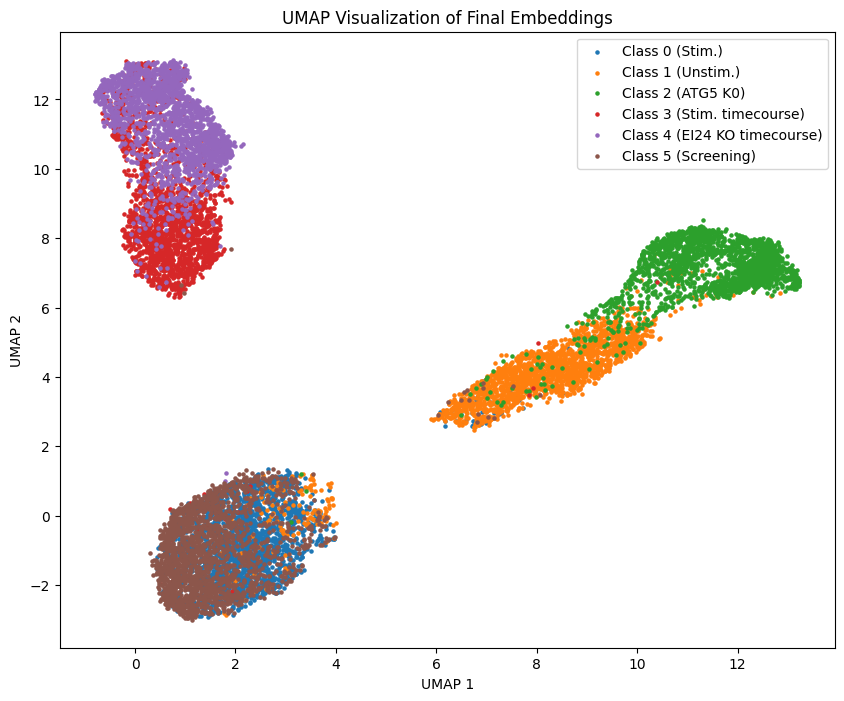

In [13]:
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"]

# Visualize UMAP
plt.figure(figsize=(10, 8))

for i, label in enumerate(class_labels):
    # Select indices for each class
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)

plt.legend()
plt.title('UMAP Visualization of Final Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

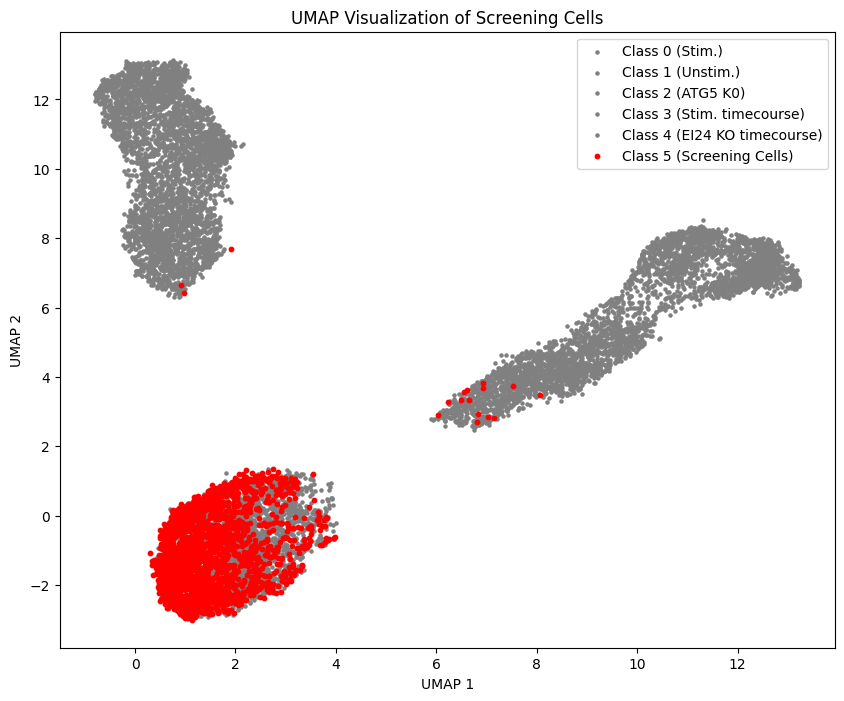

In [14]:
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Stim. timecourse)", 
                "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"]

# Plotting UMAP only for Screening cells
plt.figure(figsize=(10, 8))

# Plot cells belonging to other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Exclude the last class (screening)
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

# Plot cells belonging to class 5 (screening) with red color
screening_idx = labels_list == 5
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], color='red', label='Class 5 (Screening Cells)', s=10)

# Add legend and labels
plt.legend()
plt.title('UMAP Visualization of Screening Cells')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Show plot
plt.show()

In [15]:
# Extract UMAP coordinates
x_coords = umap_result[:, 0]  # UMAP X-coordinates
y_coords = umap_result[:, 1]  # UMAP Y-coordinates

# Identify screening cells (Class 5)
screening_idx = labels_list == 5

# Keep only Class 5 cells **outside** the block: x >= 11 and y <= 2
filtered_idx = screening_idx & ~((y_coords <= 1.75))

# Extract the filtered cell IDs
filtered_cell_ids = cell_ids_list[filtered_idx]

# Save the filtered cell IDs to a file
save_path = "./convnext_output_files/case1_100000_cells_outside_block_screening_hits.txt"
np.savetxt(save_path, filtered_cell_ids, fmt="%d")

print(f"Saved {len(filtered_cell_ids)} cell IDs to {save_path}")

Saved 17 cell IDs to ./convnext_output_files/case1_100000_cells_outside_block_screening_hits.txt


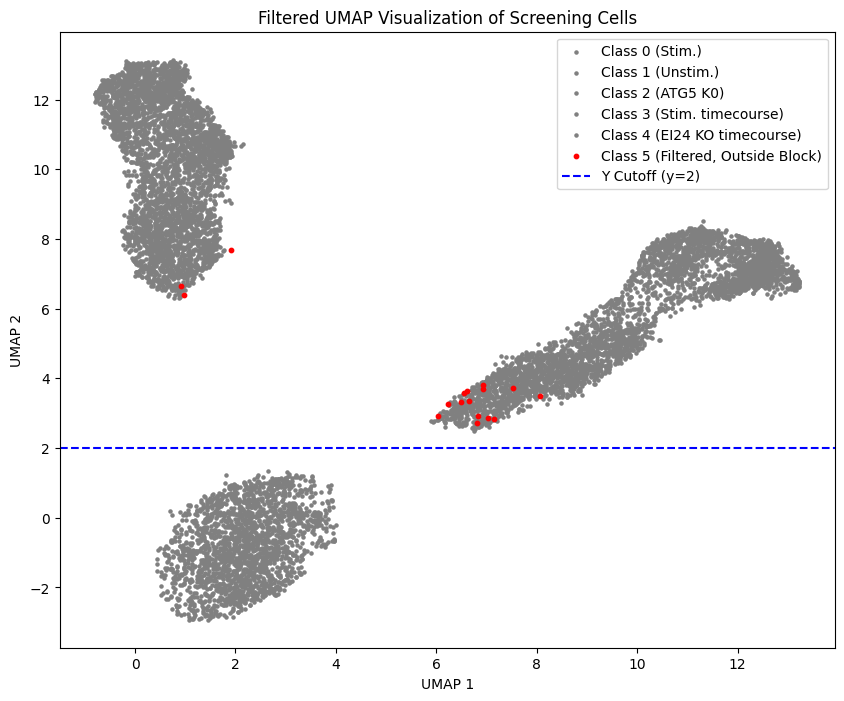

In [16]:
# Plot UMAP with Updated Cutoff
plt.figure(figsize=(10, 8))

# Plot all other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Exclude class 5
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

# Plot filtered Class 5 (Screening) cells in red (outside the block)
plt.scatter(x_coords[filtered_idx], y_coords[filtered_idx], color='red', label='Class 5 (Filtered, Outside Block)', s=10)

# Highlight the excluded region in blue
plt.axhline(y=2, color='blue', linestyle='--', label='Y Cutoff (y=2)')

plt.legend()
plt.title('Filtered UMAP Visualization of Screening Cells')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [48]:
adata = ad.AnnData(X=umap_result)

# Map numerical labels to string labels
label_map = {i: label for i, label in enumerate(class_labels)}
adata.obs['class_labels'] = labels_list
adata.obs['class_labels'] = adata.obs['class_labels'].map(label_map)

# Compute neighbors and Leiden clustering
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

colors_leiden = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
cmap_leiden = ListedColormap(colors_leiden, name='custom_discrete_cmap_leiden')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


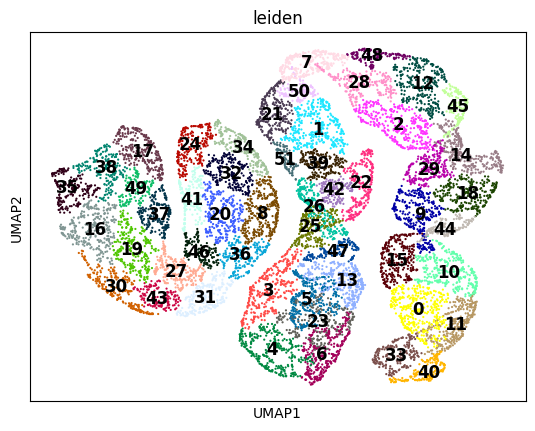

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


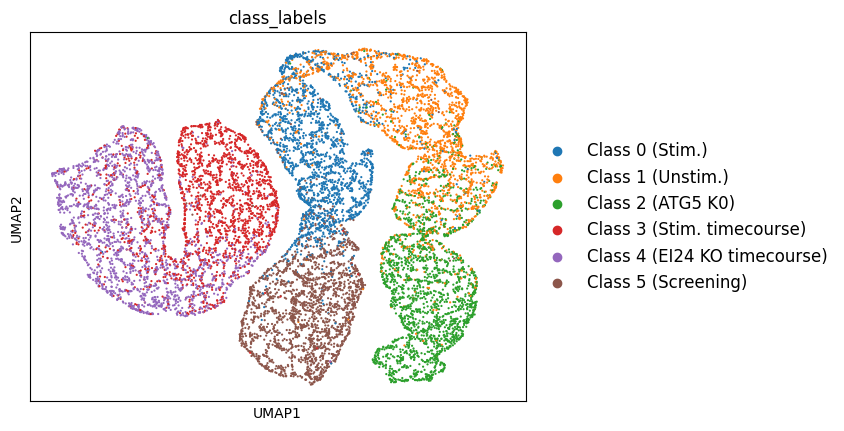

In [49]:
# Plot UMAP with Leiden clustering
sc.pl.umap(adata, color=['leiden'], cmap=cmap_leiden, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['class_labels'], cmap=cmap_leiden, legend_loc='right margin', legend_fontsize=12)

#### Case 2 [0,1,2 | balanced testset]

In [60]:
train_class_labels = [0, 1, 2] 

In [27]:
path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/'

# Create the directory if it doesn't already exist
if not os.path.exists(path):
    os.makedirs(path)
    print(f"Directory created: {path}")
else:
    print(f"Directory already exists: {path}")

Directory already exists: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/


In [54]:
!ls -l /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/
#!rm /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/trainset_*.h5

total 0
-rw-rw---- 1 di93quv pn36po 0 Feb  1 13:40 trainset_indices.pkl


In [55]:
# Create training set with separate files for selected class labels
train_filename_template = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/trainset_{label}.h5'
trainset_indices = create_trainset(full_hdf5_data, train_filename_template, testset_indices, class_labels=train_class_labels, n_samples_per_class = 1000)
#check_overlap(testset_indices, trainset_indices)

Sampling for class 0
Sampling for class 1
Sampling for class 2


In [61]:
balanced_trainset_class_0_and_1_and_2 = HDF5SingleCellDataset(
    dir_list=[f'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/trainset_{label}.h5' for label in train_class_labels],
    dir_labels=train_class_labels,  # The class labels
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/',  
    select_channel=4,  # Select the 5th channel
    return_id=False
)

Total: 3000
0: 1000
1: 1000
2: 1000


In [57]:
# Save the trainset_indices to a file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/trainset_indices.pkl', 'wb') as f:
    pickle.dump(trainset_indices, f)

In [62]:
# Load the trainset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/trainset_indices.pkl', 'rb') as f:
    trainset_indices = pickle.load(f)

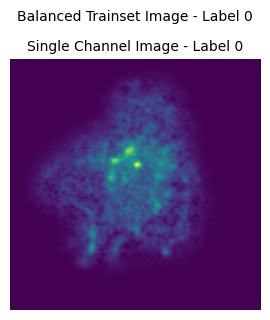

In [59]:
image_data, label = balanced_trainset_class_0_and_1_and_2[0]  # Unpack image data, label from tupel
num_channels = image_data.shape[0]  # number of channels

if num_channels == 1:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(image_data[0]) 
    ax.set_title(f"Single Channel Image - Label {label}", fontsize=10)
    ax.axis('off')

else:
    # create a subplot for each channel
    fig, axes = plt.subplots(1, num_channels, figsize=(10, 5))
    
    for channel in range(num_channels):
        axes[channel].imshow(image_data[channel])
        axes[channel].set_title(f"Channel {channel + 1}")
        axes[channel].axis('off')
        
plt.tight_layout()
plt.suptitle(f"Balanced Trainset Image - Label {label}", fontsize=10, y=1.05)
plt.show()

In [63]:
# Load data: Balanced trainset for classes 0, 1 and 2
train_class_labels = [0, 1, 2]
balanced_trainset_class_0_and_1_and_2= HDF5SingleCellDataset(
    dir_list=[
        f'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/trainset_{label}.h5'
        for label in train_class_labels
    ],
    dir_labels=train_class_labels,  # Class labels
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case2_balanced_trainingset_small/',
    select_channel=4,  # Select the 5th channel
    return_id=False
)
train_loader = DataLoader(balanced_trainset_class_0_and_1_and_2, batch_size=64, shuffle=True, num_workers=8)

Total: 3000
0: 1000
1: 1000
2: 1000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [60]:
# Set model to training mode
model.train()

# Define optimizer (Adam optimizer)
optimizer = Adam(model.parameters(), lr=1e-5)  

# Define loss function (Cross-Entropy for classification)
criterion = nn.CrossEntropyLoss()

# Track losses and accuracy
running_loss = 0.0
correct_preds = 0
total_preds = 0

def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1) 

# In the training loop, apply the conversion before passing to the model
for batch in train_loader:
    optimizer.zero_grad()  # Zero gradients before each step
    
    # Extract inputs and labels
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Convert inputs from single-channel to 3 channels
    inputs = convert_to_rgb(inputs)
    
    # Forward pass through the model
    logits, embeddings = model(inputs)
    
    # Compute loss
    loss = criterion(logits, labels)
    
    # Backward pass and optimization step
    loss.backward()
    optimizer.step()
    
    # Track accuracy
    _, predicted = torch.max(logits, 1)
    total_preds += labels.size(0)
    correct_preds += (predicted == labels).sum().item()
    
    # Accumulate loss for visualization
    running_loss += loss.item()
    
accuracy = 100 * correct_preds / total_preds
print(f'Finished one pass through training data. Accuracy: {accuracy:.2f}%')

Finished one pass through training data. Accuracy: 75.30%


In [64]:
# Define the directory and filename
save_dir = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
model_filename = "model_case_2_1000_instances.pth"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save model
model_path = os.path.join(save_dir, model_filename)

In [62]:
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/model_case_2_1000_instances.pth


In [65]:
# Load the saved model
model.load_state_dict(torch.load(model_path))
model.to(device)

ConvNextWithCustomFC(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
     

In [66]:
embeddings = []
labels_list = []
cell_ids_list = []  

model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        inputs, labels, cell_ids = batch  
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Convert inputs from single-channel to 3 channels
        inputs = convert_to_rgb(inputs)

        # Forward pass to get logits and pooler output
        _, pooler_output = model(inputs)

        # Append pooler_output, labels, and cell_ids
        embeddings.append(pooler_output.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        cell_ids_list.append(cell_ids.cpu().detach().numpy())  

# Convert to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)
cell_ids_list = np.concatenate(cell_ids_list, axis=0) 

In [67]:
import pickle
import os

# Define the save path
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
file_name = "case_2_1000_instances.pkl"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save embeddings, labels, and cell_ids using pickle
with open(os.path.join(save_path, file_name), 'wb') as f:
    pickle.dump({'embeddings': embeddings, 'labels': labels_list, 'cell_ids': cell_ids_list}, f)

print(f"Saved embeddings, labels, and cell_ids to {os.path.join(save_path, file_name)}")

Saved embeddings, labels, and cell_ids to /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/case_2_1000_instances.pkl


In [26]:
import pickle
import os

# Define the save path and file name
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
file_name = "case_2_1000_instances.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

Loaded embeddings shape: (12000, 2048)
Loaded labels shape: (12000,)
Loaded cell_ids shape: (12000,)


In [27]:
# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

# UMAP dimensionality reduction
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

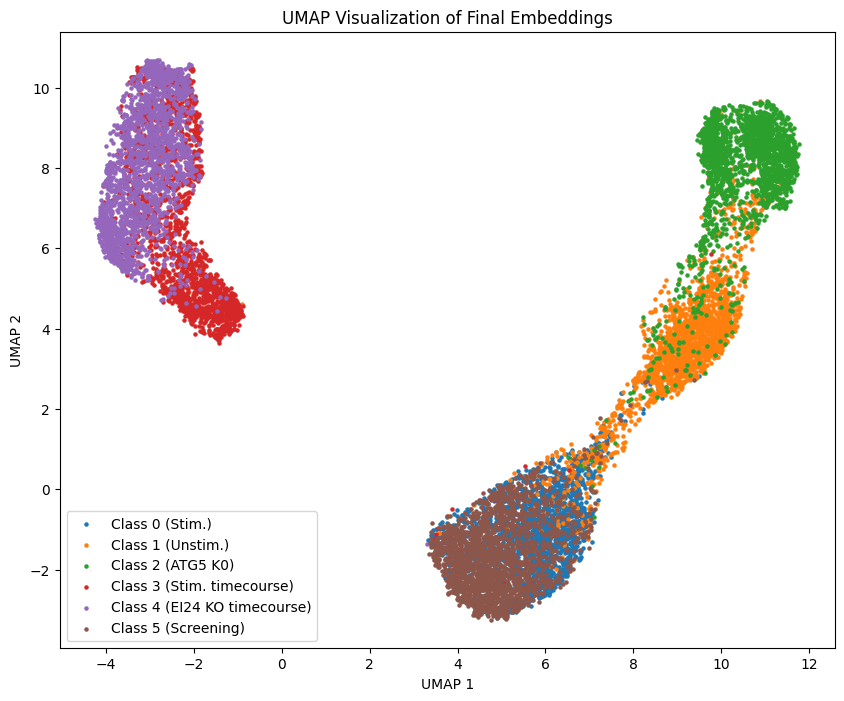

In [28]:
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"]

# Visualize UMAP
plt.figure(figsize=(10, 8))

for i, label in enumerate(class_labels):
    # Select indices for each class
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)

plt.legend()
plt.title('UMAP Visualization of Final Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

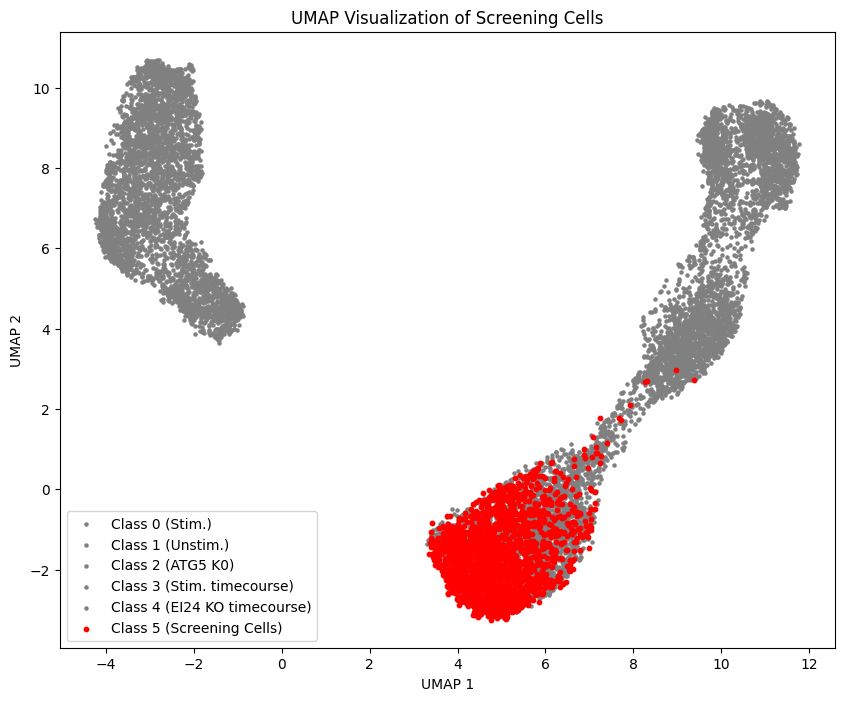

In [29]:
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Stim. timecourse)", 
                "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"]

# Plotting UMAP only for Screening cells
plt.figure(figsize=(10, 8))

# Plot cells belonging to other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Exclude the last class (screening)
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

# Plot cells belonging to class 5 (screening) with red color
screening_idx = labels_list == 5
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], color='red', label='Class 5 (Screening Cells)', s=10)
plt.legend()
plt.title('UMAP Visualization of Screening Cells')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [30]:
# Apply the cutoff filters on the UMAP results
x_coords = umap_result[:, 0]  # UMAP X-coordinates
y_coords = umap_result[:, 1]  # UMAP Y-coordinates

# Identify screening cells (Class 5)
screening_idx = labels_list == 5

# Select all screening cells (Class 5) that are **outside** the restricted region
filtered_idx = screening_idx & ~((x_coords <= 7))

# Extract filtered cell IDs
filtered_cell_ids = cell_ids_list[filtered_idx]

# Save the filtered cell IDs to a file
save_path = "./convnext_output_files/case2_1000_cells_outside_block_screening_hits.txt"
np.savetxt(save_path, filtered_cell_ids, fmt="%d")

print(f"Saved {len(filtered_cell_ids)} cell IDs to {save_path}")

Saved 26 cell IDs to ./convnext_output_files/case2_1000_cells_outside_block_screening_hits.txt


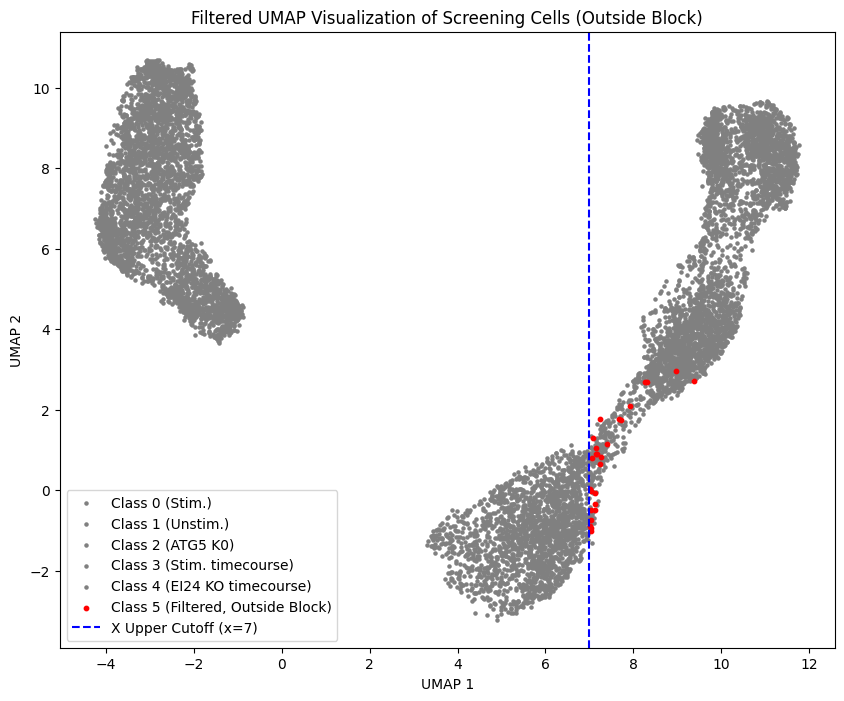

In [32]:
plt.figure(figsize=(10, 8))

# Plot all other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Exclude class 5
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

# Plot newly filtered class 5 (Screening) cells in red (those **outside** the block)
plt.scatter(x_coords[filtered_idx], y_coords[filtered_idx], color='red', label='Class 5 (Filtered, Outside Block)', s=10)

# Highlight the **excluded region** in blue
plt.axvline(x=7, color='blue', linestyle='--', label='X Upper Cutoff (x=7)')

plt.legend()
plt.title('Filtered UMAP Visualization of Screening Cells (Outside Block)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [37]:
adata = ad.AnnData(X=umap_result)

# Map numerical labels to string labels
label_map = {i: label for i, label in enumerate(class_labels)}
adata.obs['class_labels'] = labels_list
adata.obs['class_labels'] = adata.obs['class_labels'].map(label_map)

# Compute neighbors and Leiden clustering
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

colors_leiden = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
cmap_leiden = ListedColormap(colors_leiden, name='custom_discrete_cmap_leiden')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


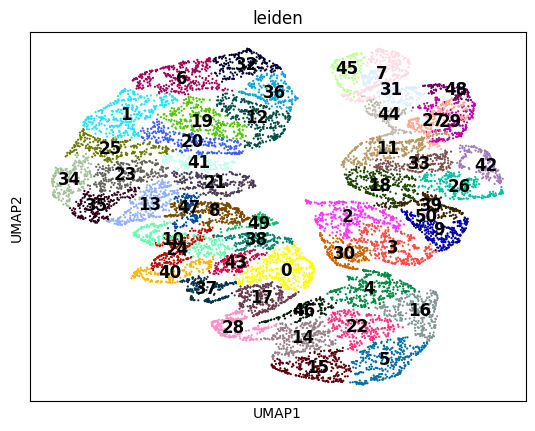

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


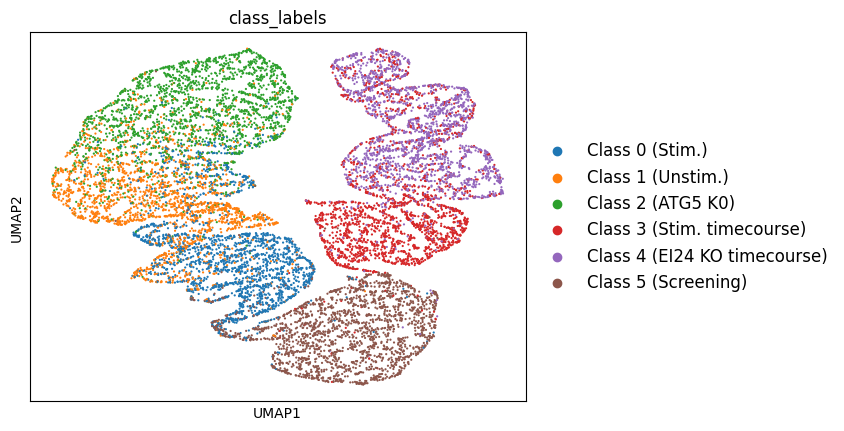

In [38]:
# Plot UMAP with Leiden clustering
sc.pl.umap(adata, color=['leiden'], cmap=cmap_leiden, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['class_labels'], cmap=cmap_leiden, legend_loc='right margin', legend_fontsize=12)

## Check for overlapping screening hit cell IDs and visualize the images for those cells

In [40]:
# Print the number of saved cell IDs per file
file_paths = {
    "ConvNeXt case 1 - 1000 cells": "./convnext_output_files/case1_1000_cells_outside_block_screening_hits.txt",
    "ConvNeXt case 1 - 100000 cells": "./convnext_output_files/case1_100000_cells_outside_block_screening_hits.txt",
    "ConvNeXt case 2 - 1000 cells": "./convnext_output_files/case2_1000_cells_outside_block_screening_hits.txt",
    "De novo case 1 - 100000 cells": "./de_novo_output_files/de_novo_outside_block_screening_hits.txt"  
}

# Load cell IDs from files
cell_id_sets = {key: set(np.loadtxt(path, dtype=int)) for key, path in file_paths.items()}

print("Cell ID counts per file:")
for key, cell_ids in cell_id_sets.items():
    print(f"{key}: {len(cell_ids)} cell IDs")

Cell ID counts per file:
ConvNeXt case 1 - 1000 cells: 21 cell IDs
ConvNeXt case 1 - 100000 cells: 16 cell IDs
ConvNeXt case 2 - 1000 cells: 26 cell IDs
De novo case 1 - 100000 cells: 46 cell IDs


In [34]:
# Find overlapping cell IDs across all four sets
overlapping_all = set.intersection(*cell_id_sets.values())

# Find pairwise overlaps
overlap_case1_1000_de_novo = cell_id_sets["ConvNeXt case 1 - 1000 cells"] & cell_id_sets["De novo case 1 - 100000 cells"]
overlap_case1_100000_de_novo = cell_id_sets["ConvNeXt case 1 - 100000 cells"] & cell_id_sets["De novo case 1 - 100000 cells"]
overlap_case2_1000_de_novo = cell_id_sets["ConvNeXt case 2 - 1000 cells"] & cell_id_sets["De novo case 1 - 100000 cells"]

# Print overlaps
print(f"\nTotal Overlapping Cell IDs in ALL SETS: {len(overlapping_all)}")
print(f"Case 1 (1000 cells) & De Novo: {len(overlap_case1_1000_de_novo)}")
print(f"Case 1 (100000 cells) & De Novo: {len(overlap_case1_100000_de_novo)}")
print(f"Case 2 (1000 cells) & De Novo: {len(overlap_case2_1000_de_novo)}")


Total Overlapping Cell IDs in ALL SETS: 4
Case 1 (1000 cells) & De Novo: 10
Case 1 (100000 cells) & De Novo: 9
Case 2 (1000 cells) & De Novo: 13


a) First let us plot the overlapping cell ID images for all 3 ConvNeXt runs alone:

In [44]:
def visualize_and_save_cells(overlapping_cell_ids, data_loader, save_path="./convnext_output_files/overlapping_cell_images.png"):
    """Visualizes images for the overlapping cell IDs in a dynamic grid, saves, and shows the result."""
    if not overlapping_cell_ids:
        print("No overlapping cell images to visualize.")
        return

    overlapping_cell_ids = list(overlapping_cell_ids)
    num_images = len(overlapping_cell_ids)
    
    # Dynamically determine grid size (rows, cols) to fit all images
    grid_cols = 10 
    grid_rows = int(np.ceil(num_images / grid_cols))  
    
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 1.5 * grid_rows))

    image_count = 0
    for images, labels, cell_ids in data_loader:
        for i in range(len(cell_ids)):
            if cell_ids[i].item() in overlapping_cell_ids:
                row, col = divmod(image_count, grid_cols)
                ax = axes[row, col] if grid_rows > 1 else axes[col]

                image_data = images[i].numpy()
                num_channels = image_data.shape[0]

                # If single-channel, show grayscale image
                if num_channels == 1:
                    ax.imshow(image_data[0], cmap='viridis')
                else:
                    ax.imshow(np.moveaxis(image_data, 0, -1))  # Reorder channels!!

                ax.set_title(f"ID: {cell_ids[i].item()}", fontsize=8)
                ax.axis("off")

                image_count += 1
                if image_count >= num_images:  
                    break  

        if image_count >= num_images:
            break  

    # Hide unused subplots
    for ax in axes.flat[image_count:]:
        ax.axis("off")

    plt.tight_layout()
    plt.title(f"Overlapping Cell Images ({num_images} total)", fontsize=10)
    
    # Save 
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"Saved overlapping cell images to {save_path}")
    plt.show()

Saved overlapping cell images to ./convnext_output_files/overlapping_cell_images.png


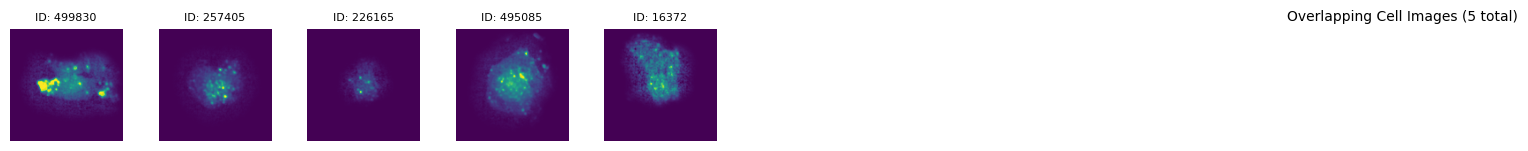

In [45]:
# Find overlapping cell IDs among the three ConvNeXt runs
overlapping_convnext = (
    cell_id_sets["ConvNeXt case 1 - 1000 cells"] & 
    cell_id_sets["ConvNeXt case 1 - 100000 cells"] & 
    cell_id_sets["ConvNeXt case 2 - 1000 cells"]
)

# Ensure it's not empty
if overlapping_convnext:
    visualize_and_save_cells(overlapping_convnext, test_data_loader)
else:
    print("No overlapping cell images found among the three ConvNeXt runs.")


Plot in UMAP where the 5 overlapping cells across all 3 ConvNeXt runs are located:

#### Run 1: ConvNext case 1 - 1000 cells

In [67]:
import pickle
import os

# Define the save path and file name
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
file_name = "case_1_1000_instances.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

#UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

Loaded embeddings shape: (12000, 2048)
Loaded labels shape: (12000,)
Loaded cell_ids shape: (12000,)


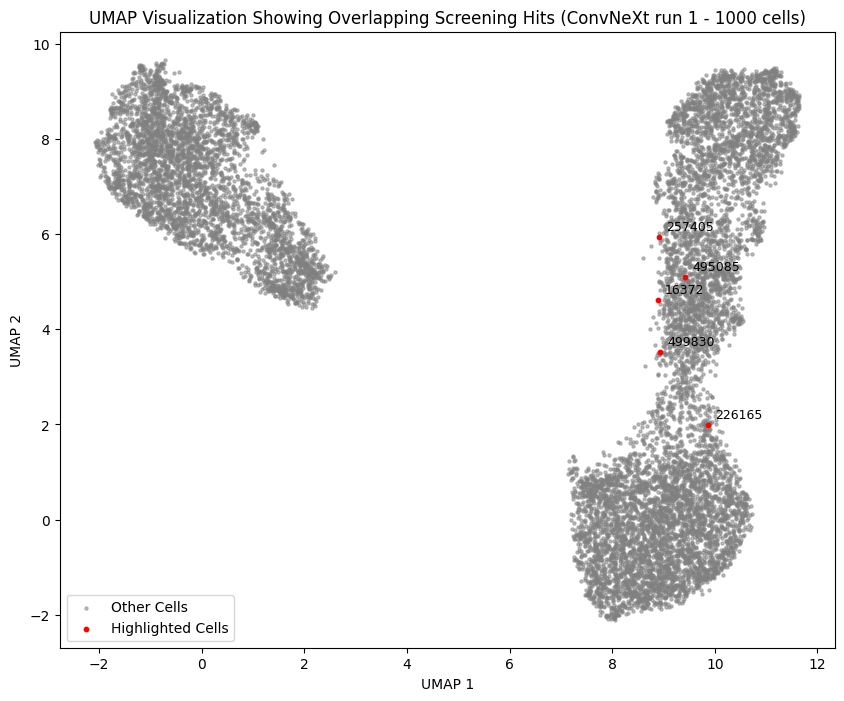

In [66]:
# Define the cell IDs to highlight
highlighted_cell_ids = np.array([16372, 495085, 499830, 226165, 257405])

# Find indices of these Cell IDs in the dataset
highlighted_indices = np.isin(cell_ids_list, highlighted_cell_ids)

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

# Plot the UMAP again with the highlighted cells
plt.figure(figsize=(10, 8))

# Plot all cells in grey
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='grey', label="Other Cells", s=5, alpha=0.5)

# Highlight specific cells in green with larger markers
plt.scatter(highlighted_x, highlighted_y, color='red', edgecolors='red', s=10, label='Highlighted Cells', marker='o')

# Add labels to each highlighted point
for i, txt in enumerate(highlighted_cell_ids):
    plt.annotate(txt, (highlighted_x[i], highlighted_y[i]), fontsize=9, color='black', xytext=(5,5), textcoords='offset points')

# Legend and formatting
plt.legend()
plt.title('UMAP Visualization Showing Overlapping Screening Hits (ConvNeXt run 1 - 1000 cells)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

#### Run 2: ConvNext case 1 - 100000 cells

In [70]:
import pickle
import os

# Define the save path and file name
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
file_name = "case_1_100000_instances.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

#UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

Loaded embeddings shape: (12000, 2048)
Loaded labels shape: (12000,)
Loaded cell_ids shape: (12000,)


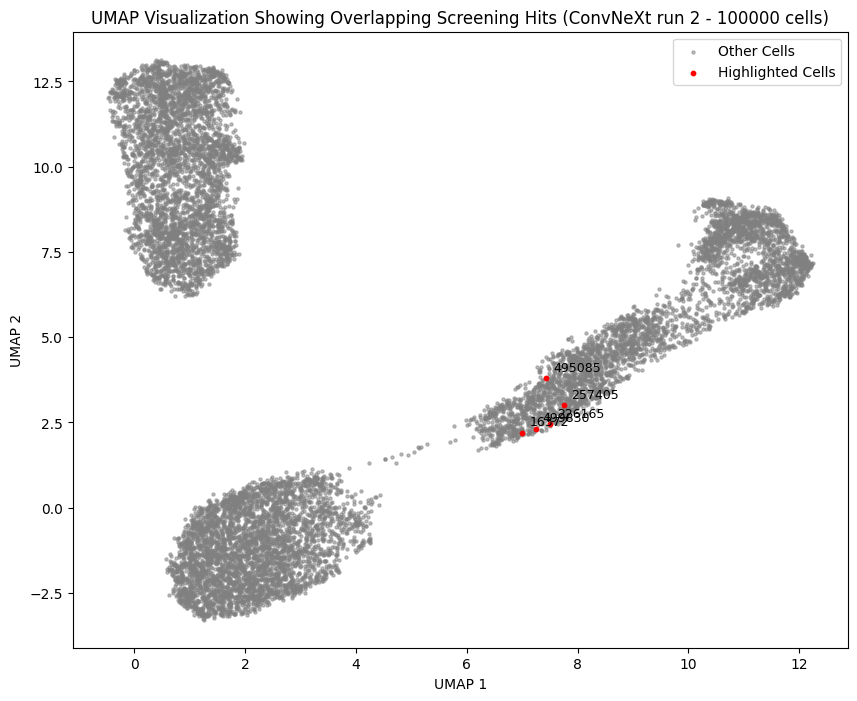

In [62]:
# Define the cell IDs to highlight
highlighted_cell_ids = np.array([16372, 495085, 499830, 226165, 257405])

# Find indices of these Cell IDs in the dataset
highlighted_indices = np.isin(cell_ids_list, highlighted_cell_ids)

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

# Plot the UMAP again with the highlighted cells
plt.figure(figsize=(10, 8))

# Plot all cells in grey
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='grey', label="Other Cells", s=5, alpha=0.5)

# Highlight specific cells in green with larger markers
plt.scatter(highlighted_x, highlighted_y, color='red', edgecolors='red', s=10, label='Highlighted Cells', marker='o')

# Add labels to each highlighted point
for i, txt in enumerate(highlighted_cell_ids):
    plt.annotate(txt, (highlighted_x[i], highlighted_y[i]), fontsize=9, color='black', xytext=(5,5), textcoords='offset points')

# Legend and formatting
plt.legend()
plt.title('UMAP Visualization Showing Overlapping Screening Hits (ConvNeXt run 2 - 100000 cells)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

#### Run 3: ConvNext case 2 - 1000 cells

In [63]:
import pickle
import os

# Define the save path and file name
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/convnext/"
file_name = "case_2_1000_instances.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

#UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

Loaded embeddings shape: (12000, 2048)
Loaded labels shape: (12000,)
Loaded cell_ids shape: (12000,)


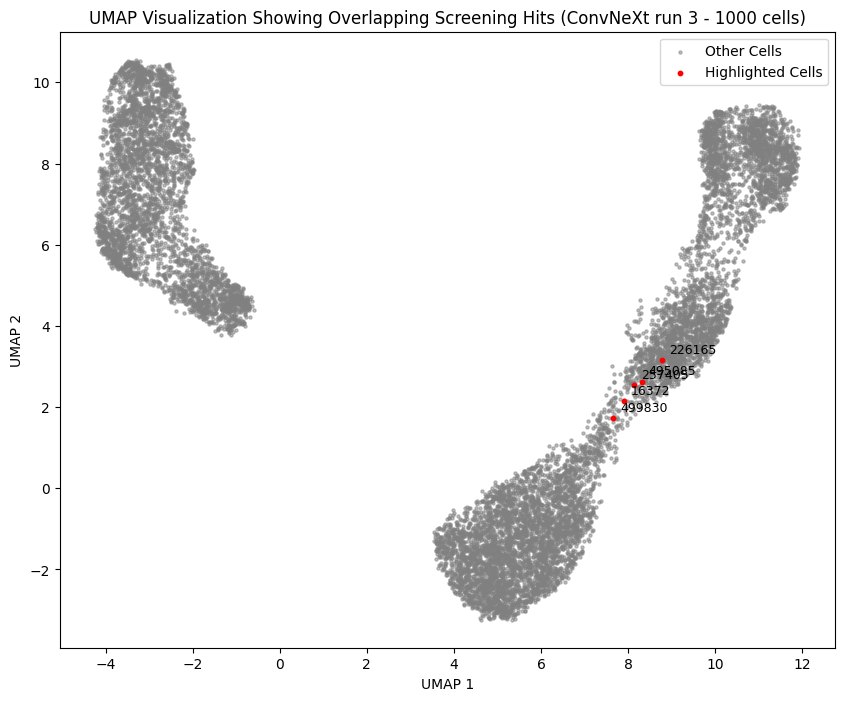

In [64]:
# Define the cell IDs to highlight
highlighted_cell_ids = np.array([16372, 495085, 499830, 226165, 257405])

# Find indices of these Cell IDs in the dataset
highlighted_indices = np.isin(cell_ids_list, highlighted_cell_ids)

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

# Plot the UMAP again with the highlighted cells
plt.figure(figsize=(10, 8))

# Plot all cells in grey
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='grey', label="Other Cells", s=5, alpha=0.5)

# Highlight specific cells in green with larger markers
plt.scatter(highlighted_x, highlighted_y, color='red', edgecolors='red', s=10, label='Highlighted Cells', marker='o')

# Add labels to each highlighted point
for i, txt in enumerate(highlighted_cell_ids):
    plt.annotate(txt, (highlighted_x[i], highlighted_y[i]), fontsize=9, color='black', xytext=(5,5), textcoords='offset points')

# Legend and formatting
plt.legend()
plt.title('UMAP Visualization Showing Overlapping Screening Hits (ConvNeXt run 3 - 1000 cells)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

b) Now including the de novo results:

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt

def visualize_and_save_cells(overlapping_cell_ids, data_loader, save_path="./convnext_output_files/overlapping_cell_images.png"):
    """Visualizes images for the overlapping cell IDs in a dynamic grid, saves, and shows the result."""
    if not overlapping_cell_ids:
        print("No overlapping cell images to visualize.")
        return

    overlapping_cell_ids = list(overlapping_cell_ids)
    num_images = len(overlapping_cell_ids)
    
    # Determine grid size dynamically
    grid_cols = 10  
    grid_rows = int(np.ceil(num_images / grid_cols))  
    
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 1.5 * grid_rows))

    image_count = 0
    for images, labels, cell_ids in data_loader:
        for i in range(len(cell_ids)):
            if cell_ids[i].item() in overlapping_cell_ids:
                row, col = divmod(image_count, grid_cols)
                ax = axes[row, col] if grid_rows > 1 else axes[col]

                image_data = images[i].numpy()
                num_channels = image_data.shape[0]

                # If single-channel, show grayscale image
                if num_channels == 1:
                    ax.imshow(image_data[0], cmap='viridis')
                else:
                    ax.imshow(np.moveaxis(image_data, 0, -1))  # Convert channel order!!

                ax.set_title(f"ID: {cell_ids[i].item()}", fontsize=8)
                ax.axis("off")

                image_count += 1
                if image_count >= num_images:  
                    break  

        if image_count >= num_images:
            break  

    # Hide unused subplots
    for ax in axes.flat[image_count:]:
        ax.axis("off")

    plt.tight_layout()
    plt.title(f"Overlapping Cell Images ({num_images} total)", fontsize=10)
    
    # Save 
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"Saved overlapping cell images to {save_path}")
    plt.show()

Saved overlapping cell images to ./convnext_output_files/overlapping_all_cell_images.png


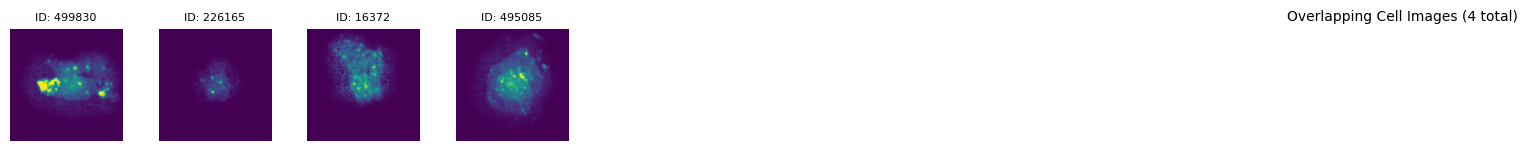

In [47]:
# Get all overlapping cell IDs across the 4 datasets
overlapping_all = set.intersection(*cell_id_sets.values())

# Visualize and save images for all overlapping cells (including De Novo)
if overlapping_all:
    visualize_and_save_cells(overlapping_all, test_data_loader, save_path="./convnext_output_files/overlapping_all_cell_images.png")

### Make Venn diagrams showing overlapping cell IDs visually

a) For all 3 ConvNeXt runs

b) For all 3 ConvNeXt runs + de novo model results

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from venn import venn

# File paths and loading cell IDs as sets
file_paths = {
    "ConvNeXt case 1 - 1000 cells": "./convnext_output_files/case1_1000_cells_outside_block_screening_hits.txt",
    "ConvNeXt case 1 - 100000 cells": "./convnext_output_files/case1_100000_cells_outside_block_screening_hits.txt",
    "ConvNeXt case 2 - 1000 cells": "./convnext_output_files/case2_1000_cells_outside_block_screening_hits.txt",
    "De novo case 1 - 100000 cells": "./de_novo_output_files/de_novo_outside_block_screening_hits.txt"
}

# Load cell IDs from files
cell_id_sets = {key: set(np.loadtxt(path, dtype=int)) for key, path in file_paths.items()}

# Define sets for the ConvNeXt runs and De Novo
set_case1_1000 = cell_id_sets["ConvNeXt case 1 - 1000 cells"]
set_case1_100000 = cell_id_sets["ConvNeXt case 1 - 100000 cells"]
set_case2_1000 = cell_id_sets["ConvNeXt case 2 - 1000 cells"]
set_de_novo = cell_id_sets["De novo case 1 - 100000 cells"]

# Venn Plot 1: ConvNeXt only (3 sets)
sets_convnext = {
    "ConvNeXt Case 1 - 1000": set_case1_1000,
    "ConvNeXt Case 1 - 100000": set_case1_100000,
    "ConvNeXt Case 2 - 1000": set_case2_1000
}

# Create the Venn diagram for the 3 ConvNeXt sets
plt.figure(figsize=(8, 6))
venn(sets_convnext)

# Title and display the first Venn diagram
plt.title("Venn Diagram of Cell ID Overlap Between ConvNeXt Runs")
plt.show()

# Venn Plot 2: ConvNeXt + De Novo (4 sets)
sets_all = {
    "ConvNeXt Case 1 - 1000": set_case1_1000,
    "ConvNeXt Case 1 - 100000": set_case1_100000,
    "ConvNeXt Case 2 - 1000": set_case2_1000,
    "De novo case 1 - 100000 cells": set_de_novo
}

# Create the Venn diagram for the 4 sets
plt.figure(figsize=(8, 6))
venn(sets_all)

# Title and display the second Venn diagram
plt.title("Venn Diagram of Cell ID Overlap Between ConvNeXt Runs and De Novo")
plt.show()

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

### Plot the cell IDs (5 + 2) from Venn diagram from ConvNeXt runs 1 and 2

We want to plot these in particular becuase we are now including the red potential screening hits in the red/purple cluster. If those overlap as well for the 2 convnext runs 1 and run 2, then it would mean we have potentially 2 different biological groups which is cool...

Saved overlapping cell images to .convnext_output_files/overlapping_cell_images_run_1_and_2.png


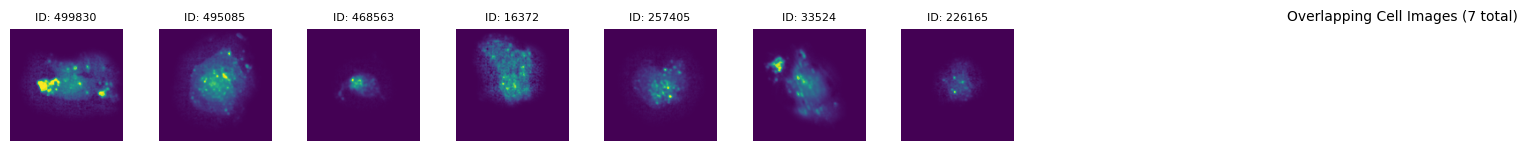

In [56]:
# Find overlapping cell IDs among the ConvNeXt runs 1 and 2
overlapping_convnext = (
    cell_id_sets["ConvNeXt case 1 - 1000 cells"] & 
    cell_id_sets["ConvNeXt case 1 - 100000 cells"] 
)

# Ensure it's not empty
if overlapping_convnext:
    visualize_and_save_cells(overlapping_convnext, test_data_loader, ".convnext_output_files/overlapping_cell_images_run_1_and_2.png")
else:
    print("No overlapping cell images found among the three ConvNeXt runs.")

For ConvNext run 1, this results in:

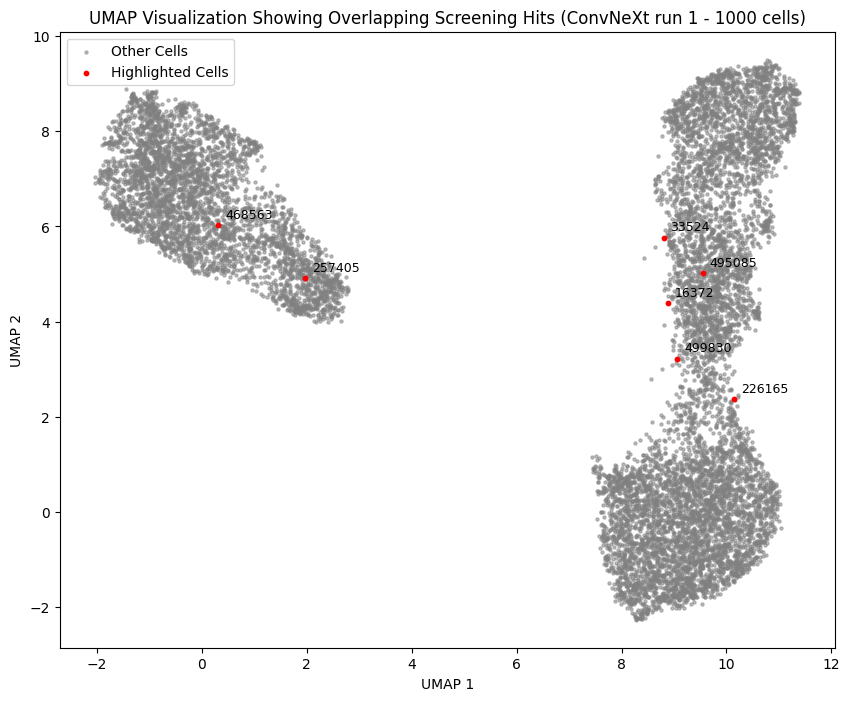

In [68]:
# Define the cell IDs to highlight
highlighted_cell_ids = np.array([16372, 495085, 499830, 226165, 257405, 468563, 33524])

# Find indices of these Cell IDs in the dataset
highlighted_indices = np.isin(cell_ids_list, highlighted_cell_ids)

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

# Plot the UMAP again with the highlighted cells
plt.figure(figsize=(10, 8))

# Plot all cells in grey
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='grey', label="Other Cells", s=5, alpha=0.5)

# Highlight specific cells in green with larger markers
plt.scatter(highlighted_x, highlighted_y, color='red', edgecolors='red', s=10, label='Highlighted Cells', marker='o')

# Add labels to each highlighted point
for i, txt in enumerate(highlighted_cell_ids):
    plt.annotate(txt, (highlighted_x[i], highlighted_y[i]), fontsize=9, color='black', xytext=(5,5), textcoords='offset points')

# Legend and formatting
plt.legend()
plt.title('UMAP Visualization Showing Overlapping Screening Hits (ConvNeXt run 1 - 1000 cells)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

For Convnext run 2 we get:

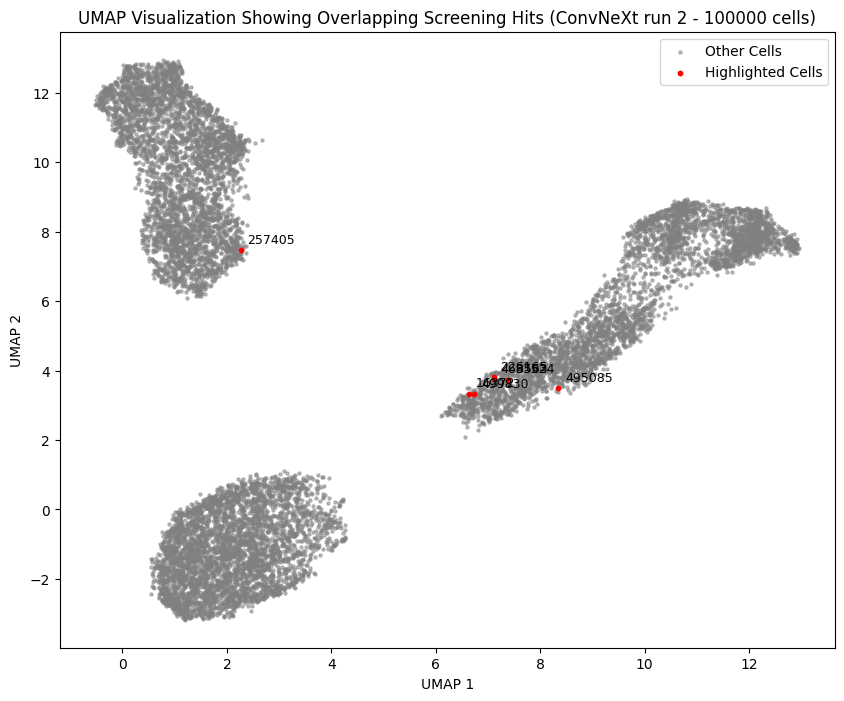

In [71]:
# Define the cell IDs to highlight
highlighted_cell_ids = np.array([16372, 495085, 499830, 226165, 257405, 468563, 33524])

# Find indices of these Cell IDs in the dataset
highlighted_indices = np.isin(cell_ids_list, highlighted_cell_ids)

# Extract UMAP coordinates of these highlighted cells
highlighted_x = umap_result[highlighted_indices, 0]
highlighted_y = umap_result[highlighted_indices, 1]

# Plot the UMAP again with the highlighted cells
plt.figure(figsize=(10, 8))

# Plot all cells in grey
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='grey', label="Other Cells", s=5, alpha=0.5)

# Highlight specific cells in green with larger markers
plt.scatter(highlighted_x, highlighted_y, color='red', edgecolors='red', s=10, label='Highlighted Cells', marker='o')

# Add labels to each highlighted point
for i, txt in enumerate(highlighted_cell_ids):
    plt.annotate(txt, (highlighted_x[i], highlighted_y[i]), fontsize=9, color='black', xytext=(5,5), textcoords='offset points')

# Legend and formatting
plt.legend()
plt.title('UMAP Visualization Showing Overlapping Screening Hits (ConvNeXt run 2 - 100000 cells)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### Compute p-value of seeing this overlap and the number of potential screening hits per run

In [52]:
import scipy.stats as stats
import scipy.special as sp

total_test_instances = 12000

# Observed screening hits in each run from my rerun before
screening_hits = {
    "ConvNeXt case 1 - 1000 cells": 21,
    "ConvNeXt case 1 - 100000 cells": 16,
    "ConvNeXt case 2 - 1000 cells": 26,
    "De novo case 1 - 100000 cells": 46
}

# Probability of a single cell ID being selected by chance
p_random = 1 / total_test_instances

# Compute p-values for each run: binomial test
p_values_hits = {}
for run, hits in screening_hits.items():
    p_value = 1 - stats.binom.cdf(hits - 1, total_test_instances, p_random)
    p_values_hits[run] = p_value

print("P-values for screening hits in each run:")
for run, p_val in p_values_hits.items():
    print(f"{run}: {p_val:.4e}")

P-values for screening hits in each run:
ConvNeXt case 1 - 1000 cells: 0.0000e+00
ConvNeXt case 1 - 100000 cells: 1.8541e-14
ConvNeXt case 2 - 1000 cells: 0.0000e+00
De novo case 1 - 100000 cells: 0.0000e+00


In [54]:
# Observed overlap of 4 cell IDs across all runs
overlap_all_runs = 4

# hypergeometric test
N = total_test_instances
M = sum(screening_hits.values())  # Total observed screening hits across all runs
n = min(screening_hits.values())  # Min number of hits in a single run (smallest set size)

# P-value for seeing at least 4 overlaps
p_value_overlap = 1 - stats.hypergeom.cdf(overlap_all_runs - 1, N, M, n)

print(f"\nP-value for observing an overlap of 4 IDs across all runs: {p_value_overlap:.4e}")

# Signif threshold
alpha = 0.05
if p_value_overlap < alpha:
    print("The overlap of 4 IDs is statistically significant (p < 0.05).")
else:
    print("The overlap of 4 IDs is NOT statistically significant (p >= 0.05).")


P-value for observing an overlap of 4 IDs across all runs: 1.0778e-05
The overlap of 4 IDs is statistically significant (p < 0.05).


In [55]:
# New values considering only the 3 ConvNeXt runs
M_convnext = screening_hits["ConvNeXt case 1 - 1000 cells"] + \
             screening_hits["ConvNeXt case 1 - 100000 cells"] + \
             screening_hits["ConvNeXt case 2 - 1000 cells"]

n_convnext = min(screening_hits["ConvNeXt case 1 - 1000 cells"], 
                 screening_hits["ConvNeXt case 1 - 100000 cells"], 
                 screening_hits["ConvNeXt case 2 - 1000 cells"])

overlap_convnext = 5  

# Compute new p-value
p_value_overlap_convnext = 1 - stats.hypergeom.cdf(overlap_convnext - 1, N, M_convnext, n_convnext)

print(f"\nP-value for observing an overlap of 5 IDs across the three ConvNeXt runs: {p_value_overlap_convnext:.4e}")

if p_value_overlap_convnext < alpha:
    print("The overlap of 5 IDs in the three ConvNeXt runs is statistically significant (p < 0.05).")
else:
    print("The overlap of 5 IDs in the three ConvNeXt runs is NOT statistically significant (p >= 0.05).")


P-value for observing an overlap of 5 IDs across the three ConvNeXt runs: 1.4175e-08
The overlap of 5 IDs in the three ConvNeXt runs is statistically significant (p < 0.05).
